In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import LeaveOneOutEncoder

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier

<IPython.core.display.Javascript object>

In [3]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor


def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

### Import Data

In [4]:
data = "Data/nfl_stadiums.csv"
data2 = "Data/nfl_teams.csv"
data3 = "Data/spreadspoke_scores.csv"

dfstad = pd.read_csv(data, encoding="unicode_escape")
dfteam = pd.read_csv(data2)
dfscore = pd.read_csv(data3)

<IPython.core.display.Javascript object>

### Initial EDA

In [5]:
dfscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934 entries, 0 to 12933
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        12934 non-null  object 
 1   schedule_season      12934 non-null  int64  
 2   schedule_week        12934 non-null  object 
 3   schedule_playoff     12934 non-null  bool   
 4   team_home            12934 non-null  object 
 5   score_home           12797 non-null  float64
 6   score_away           12797 non-null  float64
 7   team_away            12934 non-null  object 
 8   team_favorite_id     10318 non-null  object 
 9   spread_favorite      10318 non-null  float64
 10  over_under_line      10308 non-null  object 
 11  stadium              12934 non-null  object 
 12  stadium_neutral      12934 non-null  bool   
 13  weather_temperature  12008 non-null  float64
 14  weather_wind_mph     12008 non-null  float64
 15  weather_humidity     8388 non-null  

<IPython.core.display.Javascript object>

In [6]:
# Drop columns
dfscore = dfscore.replace(r"^\s*$", np.nan, regex=True)
dfscore = dfscore.drop(
    columns=[
        "weather_humidity",
        "weather_detail",
        "weather_temperature",
        "weather_wind_mph",
        "schedule_date",
        "schedule_playoff",
        "stadium",
        "stadium_neutral",
    ]
)

<IPython.core.display.Javascript object>

In [7]:
# Filter dataframe
dfscore = dfscore[
    (dfscore["score_home"].isna() == False)
    & (dfscore["team_favorite_id"].isna() == False)
    & (dfscore["over_under_line"].isna() == False)
    & (dfscore["schedule_season"] >= 2015)
]

<IPython.core.display.Javascript object>

In [8]:
dfscore.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

### Feature Engineering

In [9]:
# Create features; Mean home and away score columns
home_scores = (
    dfscore[
        [
            "score_home",
            "schedule_season",
            "team_home",
        ]
    ]
    .groupby(["schedule_season", "team_home"])
    .mean()
    .reset_index()
)

away_scores = (
    dfscore[
        [
            "score_away",
            "schedule_season",
            "team_away",
        ]
    ]
    .groupby(["schedule_season", "team_away"])
    .mean()
    .reset_index()
)


dfscoreh = pd.merge(dfscore, home_scores, on=["team_home", "schedule_season"])

dfscoreb = pd.merge(dfscoreh, away_scores, on=["team_away", "schedule_season"])
dfscore = dfscoreb
dfscore["score_home"] = dfscore["score_home_x"]
dfscore["score_away"] = dfscore["score_away_x"]
dfscore["mean_home"] = dfscore["score_home_y"]
dfscore["mean_away"] = dfscore["score_away_y"]
dfscore = dfscore.drop(
    columns=["score_home_x", "score_away_x", "score_home_y", "score_away_y"]
)
dfscore.head(2)

,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,score_home,score_away,mean_home,mean_away
0,2015,1,New England Patriots,Pittsburgh Steelers,NE,-7.0,51,28.0,21.0,31.111111,21.2
1,2015,Division,Denver Broncos,Pittsburgh Steelers,DEN,-7.5,41,23.0,16.0,21.818182,21.2


<IPython.core.display.Javascript object>

In [10]:
# reformat to float
dfscore["over_under_line"] = dfscore["over_under_line"].astype(float)

<IPython.core.display.Javascript object>

In [11]:
# Use other dataframe to map team ids

dfscore["team_home"] = dfscore["team_home"].map(
    dfteam.set_index("team_name")["team_id"].to_dict()
)
dfscore["team_away"] = dfscore["team_away"].map(
    dfteam.set_index("team_name")["team_id"].to_dict()
)

<IPython.core.display.Javascript object>

In [12]:
# Create columns for home and away favorites.
dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_home"], "home_favorite"] = 1
dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_away"], "away_favorite"] = 1
dfscore["home_favorite"].fillna(0, inplace=True)
dfscore["away_favorite"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [13]:
dfscore.head(2)

,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,score_home,score_away,mean_home,mean_away,home_favorite,away_favorite
0,2015,1,NE,PIT,NE,-7.0,51.0,28.0,21.0,31.111111,21.2,1.0,0.0
1,2015,Division,DEN,PIT,DEN,-7.5,41.0,23.0,16.0,21.818182,21.2,1.0,0.0


<IPython.core.display.Javascript object>

In [14]:
# feature added; 'is over' column
dfscore.loc[
    ((dfscore["score_home"] + dfscore["score_away"]) > dfscore["over_under_line"]),
    "is_over",
] = 1
dfscore["is_over"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [15]:
# Create features to show if favorited team beats spread or simply wins ml. 
dfscore["away_w_fav"] = 0
dfscore["home_w_fav"] = 0
dfscore["away_ml_fav"] = 0
dfscore["home_ml_fav"] = 0


dfscore.loc[
    (
        (
            dfscore["score_away"] - dfscore["score_home"]
            > np.abs(dfscore["spread_favorite"])
        )
        & (dfscore["away_favorite"] == 1)
    ),
    "away_w_fav",
] = 1

dfscore.loc[
    (
        (
            dfscore["score_away"] > dfscore["score_home"]
        )
        & (dfscore["away_favorite"] == 1)
    ),
    "away_ml_fav",
] = 1



dfscore.loc[
    (
        (
            dfscore["score_home"] - dfscore["score_away"]
            > np.abs(dfscore["spread_favorite"])
        )
        & (dfscore["home_favorite"] == 1)
    ),
    "home_w_fav",
] = 1

dfscore.loc[
    (
        (
            dfscore["score_home"] > dfscore["score_away"]
        )
        & (dfscore["home_favorite"] == 1)
    ),
    "home_ml_fav",
] = 1



<IPython.core.display.Javascript object>

### More EDA

In [16]:
# looking  at statistics of how often the favored team team wins or covers a spread.
# Home win (~68%), covers (~47%)
# Away win (~62%), covers (~47%)

display(dfscore[dfscore["away_favorite"] == 1].describe().transpose())
dfscore[dfscore["home_favorite"] == 1].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
schedule_season,513.0,2017.296296,1.587895,2015.000,2016.000,2017.000,2019.000,2020.00
spread_favorite,513.0,-4.359649,2.877850,-18.000,-6.000,-3.000,-2.500,-1.00
over_under_line,513.0,45.274854,4.252813,35.000,42.000,45.000,48.000,57.50
score_home,513.0,19.988304,9.906588,0.000,13.000,20.000,26.000,57.00
score_away,513.0,24.352827,10.017284,0.000,17.000,24.000,31.000,59.00
mean_home,513.0,21.384420,4.239995,12.250,18.625,21.125,23.625,36.00
mean_away,513.0,23.640178,4.759374,13.875,20.875,23.375,26.875,38.25
home_favorite,513.0,0.000000,0.000000,0.000,0.000,0.000,0.000,0.00
away_favorite,513.0,1.000000,0.000000,1.000,1.000,1.000,1.000,1.00
is_over,513.0,0.461988,0.499040,0.000,0.000,0.000,1.000,1.00


,count,mean,std,min,25%,50%,75%,max
schedule_season,934.0,2017.230193,1.582836,2015.00,2016.000000,2017.00,2019.000000,2020.00
spread_favorite,934.0,-5.676124,3.527305,-21.50,-7.500000,-5.00,-3.000000,-1.00
over_under_line,934.0,45.771413,4.273218,36.50,43.000000,45.50,48.500000,63.50
score_home,934.0,25.900428,9.555150,0.00,20.000000,26.00,31.000000,54.00
score_away,934.0,20.724839,9.418590,0.00,14.000000,20.00,27.000000,55.00
mean_home,934.0,25.114116,4.513103,12.25,22.000000,24.50,28.444444,36.00
mean_away,934.0,21.156332,4.564613,8.25,17.888889,21.25,24.000000,38.25
home_favorite,934.0,1.000000,0.000000,1.00,1.000000,1.00,1.000000,1.00
away_favorite,934.0,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00
is_over,934.0,0.495717,0.500250,0.00,0.000000,0.00,1.000000,1.00


<IPython.core.display.Javascript object>

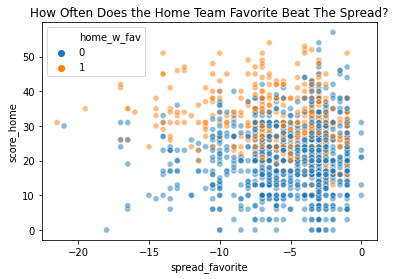

<IPython.core.display.Javascript object>

In [17]:
# Visualize data relationships
sns.scatterplot(
    x="spread_favorite", y="score_home", hue="home_w_fav", alpha=0.5, data=dfscore
)
plt.title('How Often Does the Home Team Favorite Beat The Spread?')
plt.legend()
plt.show()



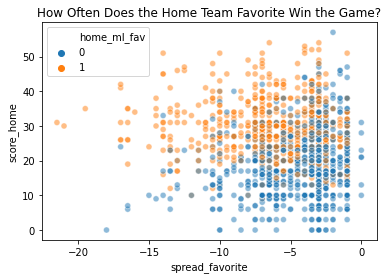

<IPython.core.display.Javascript object>

In [18]:
sns.scatterplot(
    x="spread_favorite", y="score_home", hue="home_ml_fav", alpha=0.5, data=dfscore
)
plt.title("How Often Does the Home Team Favorite Win the Game?")
plt.show()

### Feature prep for models

In [19]:
# Assign numbers to week names to prep the 'schedule_week' column.

dfscore.loc[(dfscore.schedule_week == "18"), "schedule_week"] = "17"
dfscore.loc[
    (dfscore.schedule_week == "Wildcard") | (dfscore.schedule_week == "WildCard"),
    "schedule_week",
] = "18"
dfscore.loc[(dfscore.schedule_week == "Division"), "schedule_week"] = "19"
dfscore.loc[(dfscore.schedule_week == "Conference"), "schedule_week"] = "20"
dfscore.loc[
    (dfscore.schedule_week == "Superbowl") | (dfscore.schedule_week == "SuperBowl"),
    "schedule_week",
] = "21"
dfscore["schedule_week"] = dfscore.schedule_week.astype(int)
dfscore["schedule_week"]

0        1
1       19
2        5
3        3
4        7
        ..
1449     5
1450     2
1451     7
1452     5
1453     4
Name: schedule_week, Length: 1454, dtype: int64

<IPython.core.display.Javascript object>

In [20]:
# Shorten the season weeks to analyze mid week.
# Reasoning - early weeks and late weeks have different strategies.
#    .... Mid season weeks have more strategic uniformity.
dfss = dfscore[(dfscore["schedule_week"] >= 3) & (dfscore["schedule_week"] <= 15)]
dfss_copy = dfss.copy()

<IPython.core.display.Javascript object>

In [21]:
# With the analysis on mid season, we can experiment with
# score lag columns.

# Here we create columns to lag 1 & 2 weeks in a new df...
# Then refactor
home_lag_df = dfscore[
    [
        "schedule_season",
        "schedule_week",
        "team_home",
        "score_home",
        "home_w_fav",
        "home_ml_fav",
    ]
]
home_lag_df = home_lag_df.rename(
    columns={
        "team_home": "team",
        "score_home": "score",
        "home_w_fav": "w_fav",
        "home_ml_fav": "ml_fav",
    }
)
away_lag_df = dfscore[
    [
        "schedule_season",
        "schedule_week",
        "team_away",
        "score_away",
        "away_w_fav",
        "away_ml_fav",
    ]
]
away_lag_df = away_lag_df.rename(
    columns={
        "team_away": "team",
        "score_away": "score",
        "away_w_fav": "w_fav",
        "away_ml_fav": "ml_fav",
    }
)
lag_df = pd.concat((away_lag_df, home_lag_df))
lag_df = lag_df.sort_values(["schedule_season", "team", "schedule_week"])


# Create lag variables for a team's prior 2 game scores
# create new shifts for new columns
lag_df["score_lag_1"] = lag_df.groupby(["schedule_season", "team"])["score"].shift(
    periods=1
)
lag_df["score_lag_2"] = lag_df.groupby(["schedule_season", "team"])["score"].shift(
    periods=2
)

lag_df["spread_lag_1"] = lag_df.groupby(["schedule_season", "team"])["w_fav"].shift(
    periods=1
)
lag_df["spread_lag_2"] = lag_df.groupby(["schedule_season", "team"])["w_fav"].shift(
    periods=2
)

lag_df["ml_lag_1"] = lag_df.groupby(["schedule_season", "team"])["ml_fav"].shift(
    periods=1
)
lag_df["ml_lag_2"] = lag_df.groupby(["schedule_season", "team"])["ml_fav"].shift(
    periods=2
)

lag_df.head()

,schedule_season,schedule_week,team,score,w_fav,ml_fav,score_lag_1,score_lag_2,spread_lag_1,spread_lag_2,ml_lag_1,ml_lag_2
76,2015,1,ARI,31.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
185,2015,2,ARI,48.0,1,1,31.0,NaN,1.0,NaN,1.0,NaN
84,2015,3,ARI,47.0,1,1,48.0,31.0,1.0,1.0,1.0,1.0
92,2015,4,ARI,22.0,0,0,47.0,48.0,1.0,1.0,1.0,1.0
192,2015,5,ARI,42.0,1,1,22.0,47.0,0.0,1.0,0.0,1.0


<IPython.core.display.Javascript object>

In [22]:
# Add new columns for home away merges to main df.
dfssm = pd.merge(dfss, lag_df, left_on=['schedule_season','schedule_week','team_home'], right_on=['schedule_season', 'schedule_week','team'])
dfssm = dfssm.rename(columns = {'score_lag_1': 'home_sl_1', 'score_lag_2':'home_sl_2', 'spread_lag_1': 'h_sprl_1',
                               'spread_lag_2': 'h_sprl_2', 
                               'ml_lag_1': 'h_mll_1',
                               'ml_lag_2': 'h_mll_2'})
dfssm = dfssm.drop(columns= ['score','team', 'w_fav', 'ml_fav'])

dfssm = pd.merge(dfssm, lag_df, left_on=['schedule_season','schedule_week','team_away'], right_on=['schedule_season', 'schedule_week','team'])
dfssm = dfssm.rename(columns = {'score_lag_1': 'away_sl_1', 'score_lag_2':'away_sl_2',
                                'spread_lag_1': 'a_sprl_1',
                               'spread_lag_2': 'a_sprl_2', 
                               'ml_lag_1': 'a_mll_1',
                               'ml_lag_2': 'a_mll_2'})
dfssm = dfssm.drop(columns= ['score','team', 'w_fav', 'ml_fav'])

#dfss = pd.merge(dfssm, score_df, left_on=['schedule_season','schedule_week','team_away'], right_on=['schedule_season', 'schedule_week','team'])


<IPython.core.display.Javascript object>

In [23]:
dfss = dfssm.dropna()
dfss_copy = dfss.copy()
dfss.isna().sum()

schedule_season     0
schedule_week       0
team_home           0
team_away           0
team_favorite_id    0
spread_favorite     0
over_under_line     0
score_home          0
score_away          0
mean_home           0
mean_away           0
home_favorite       0
away_favorite       0
is_over             0
away_w_fav          0
home_w_fav          0
away_ml_fav         0
home_ml_fav         0
home_sl_1           0
home_sl_2           0
h_sprl_1            0
h_sprl_2            0
h_mll_1             0
h_mll_2             0
away_sl_1           0
away_sl_2           0
a_sprl_1            0
a_sprl_2            0
a_mll_1             0
a_mll_2             0
dtype: int64

<IPython.core.display.Javascript object>

In [24]:
# Checking work

# dfss[dfss["schedule_season"] == 2018].sort_values(by="schedule_week").head(20)

<IPython.core.display.Javascript object>

In [25]:
# corelation heatmap

# plt.figure(figsize=(20, 15))
# sns.heatmap(dfss.corr(), vmin=-1, vmax=1, annot=True)
# plt.show()

<IPython.core.display.Javascript object>

In [26]:
print(dfss.columns)

Index(['schedule_season', 'schedule_week', 'team_home', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'score_home',
       'score_away', 'mean_home', 'mean_away', 'home_favorite',
       'away_favorite', 'is_over', 'away_w_fav', 'home_w_fav', 'away_ml_fav',
       'home_ml_fav', 'home_sl_1', 'home_sl_2', 'h_sprl_1', 'h_sprl_2',
       'h_mll_1', 'h_mll_2', 'away_sl_1', 'away_sl_2', 'a_sprl_1', 'a_sprl_2',
       'a_mll_1', 'a_mll_2'],
      dtype='object')


<IPython.core.display.Javascript object>

### Modeling - Try XGBoost

In [27]:
# Removed columns if they are items that have colinearity or are too informative.
# i.e. post game stats for the current week prediction.

X = dfss.drop(
    columns=[
        "schedule_season",
        "schedule_week",
        # "team_home",
        # "team_away",
        "team_favorite_id",
        #'spread_favorite',
        "over_under_line",
        "score_home",
        "score_away",
        # "mean_home",
        # "mean_away",
        # "home_favorite",
        "away_favorite",
        "is_over",
        "away_w_fav",
        "home_w_fav",
        "away_ml_fav",
        "home_ml_fav",
        "home_sl_1",
        "home_sl_2",
        "h_sprl_1",
        "h_sprl_2",
        "h_mll_1",
        "h_mll_2",
        "away_sl_1",
        "away_sl_2",
        "a_sprl_1",
        "a_sprl_2",
        "a_mll_1",
        "a_mll_2",
    ]
)
y = dfss["home_ml_fav"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [28]:
X.columns

Index(['team_home', 'team_away', 'spread_favorite', 'mean_home', 'mean_away',
       'home_favorite'],
      dtype='object')

<IPython.core.display.Javascript object>

In [37]:
bin_cols = [
    # "is_over",
    "home_favorite",
    # "away_favorite",
    # "away_w_fav",
    # "home_w_fav",
    # "away_ml_fav",
    # "home_ml_fav",
    # "h_sprl_1",
    # "h_sprl_2",
    # "h_mll_1",
    # "h_mll_2",
    # "a_sprl_1",
    # "a_sprl_2",
    # "a_mll_1",
    # "a_mll_2",
]
num_cols = [
    "spread_favorite",
    "mean_home",
    "mean_away",
    # "over_under_line",
    # "home_sl_1",
    # "home_sl_2",
    # "away_sl_1",
    # "away_sl_2",
    # "score_dif",
]
cat_cols = [
    # "schedule_week",
    "team_home",
    "team_away",
    # "team_favorite_id",
]

prep = ColumnTransformer(
    [
        ("leave_one", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

### Fit and Eval

In [38]:
transformed = prep.fit_transform(X_train, y_train)
# ToDO get printVIF and run it.
type(transformed)
# ToD0, create dataframe with transformed.
transformed = pd.DataFrame(transformed, columns=X_train.columns)
print_vif(transformed)

VIF results
-------------------------------
const              67.177657
team_home           1.254848
team_away           1.179346
spread_favorite     1.083528
mean_home           1.310851
mean_away           1.182066
home_favorite       1.396976
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

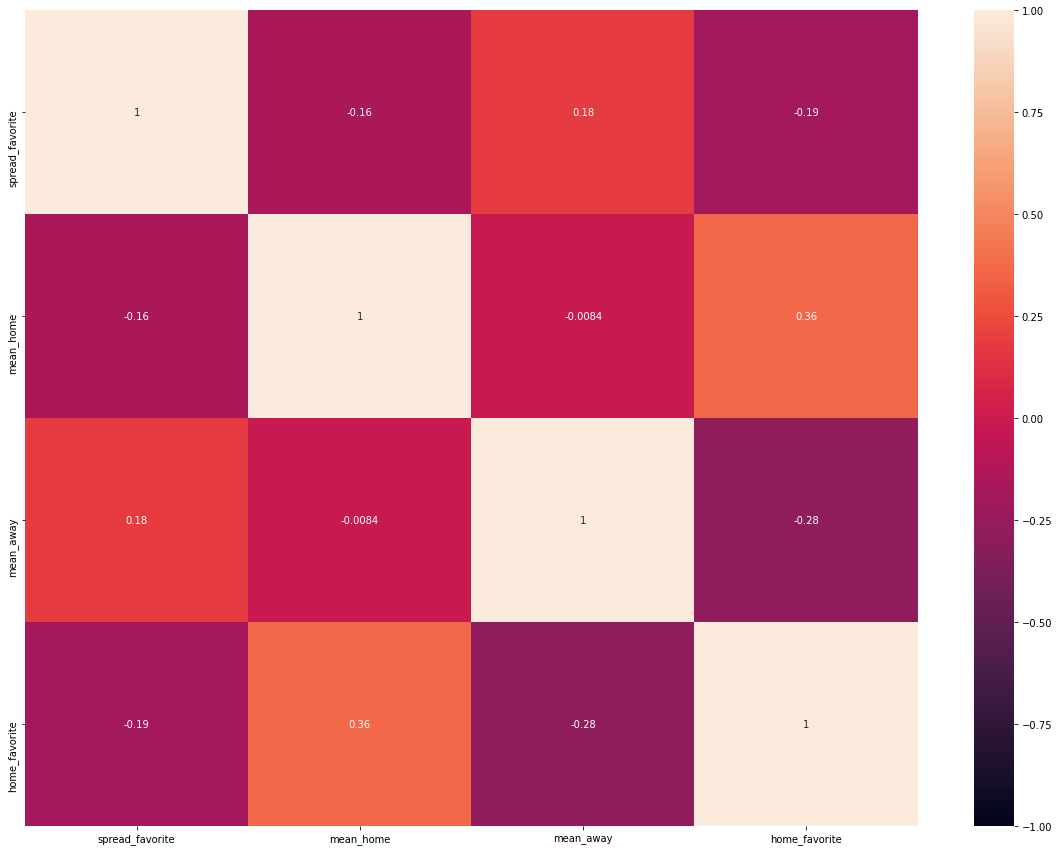

<IPython.core.display.Javascript object>

In [31]:
# Looking for correlations over .5 -- There is only one, and that is ok.
plt.figure(figsize=(20, 15))
sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [32]:
n_trees = 100
# learning_rate = ([0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],)

x_pipe = Pipeline(
    [
        ("prep", prep),
        ("xgb", XGBClassifier(n_estimators=n_trees, learning_rate=0.01 / n_trees)),
    ]
)

x_grid = {
    "xgb__subsample": [0.5, 0.75, 1],
    "xgb__colsample_bytree": [0.5, 0.75, 1],
    "xgb__max_depth": [2, 3, 4, 5],
}

x_pipe_cv = GridSearchCV(x_pipe, x_grid, cv=4, n_jobs=-1)

<IPython.core.display.Javascript object>

In [33]:
x_pipe_cv.fit(X_train, y_train)

print("Best params:")
print(x_pipe_cv.best_params_)

print(f"\ntrain score: {x_pipe_cv.score(X_train, y_train):.3f}")
print(f"test score: {x_pipe_cv.score(X_test, y_test):.3f}\n")

y_predx = x_pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_predx))
print(classification_report(y_test, y_predx))

[12:29:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:
{'xgb__colsample_bytree': 0.75, 'xgb__max_depth': 2, 'xgb__subsample': 0.75}

train score: 0.824
test score: 0.800

[[89 27]
 [15 79]]
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       116
           1       0.75      0.84      0.79        94

    accuracy                           0.80       210
   macro avg       0.80      0.80      0.80       210
weighted avg       0.81      0.80      0.80       210



/Users/JasonB/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<IPython.core.display.Javascript object>

In [59]:
encoded = LeaveOneOutEncoder().fit_transform(X_test, y_test)
df_test = pd.concat((encoded, y_test), axis=1)
EX_test = df_test.drop(columns="home_ml_fav")
display(X_test)
EX_test

,team_home,team_away,spread_favorite,mean_home,mean_away,home_favorite
775,DAL,MIN,-3.0,32.125,24.800000,1.0
280,SF,NO,-5.0,20.375,27.625000,0.0
631,LVR,SEA,-3.0,22.375,24.666667,0.0
318,NYG,CIN,0.0,21.000,17.125000,0.0
1010,MIN,TEN,-2.5,29.000,22.333333,0.0
...,...,...,...,...,...,...
686,CAR,CIN,-2.5,25.500,21.875000,1.0
620,JAX,HOU,-3.5,16.000,24.375000,1.0
321,LAR,MIA,-1.0,12.375,19.111111,0.0
1009,CIN,TEN,-7.0,27.750,22.333333,0.0


,team_home,team_away,spread_favorite,mean_home,mean_away,home_favorite
775,0.285714,0.142857,-3.0,32.125,24.800000,1.0
280,0.285714,0.600000,-5.0,20.375,27.625000,0.0
631,0.500000,0.000000,-3.0,22.375,24.666667,0.0
318,0.333333,0.750000,0.0,21.000,17.125000,0.0
1010,0.800000,0.500000,-2.5,29.000,22.333333,0.0
...,...,...,...,...,...,...
686,0.666667,0.500000,-2.5,25.500,21.875000,1.0
620,0.214286,0.600000,-3.5,16.000,24.375000,1.0
321,0.222222,0.666667,-1.0,12.375,19.111111,0.0
1009,0.333333,0.500000,-7.0,27.750,22.333333,0.0


<IPython.core.display.Javascript object>

In [60]:
# Un nest XGB then run predict proba to get probaility score ideas
pred_prob_0 = x_pipe_cv.best_estimator_["xgb"].predict_proba(EX_test)[:, 0]


<IPython.core.display.Javascript object>

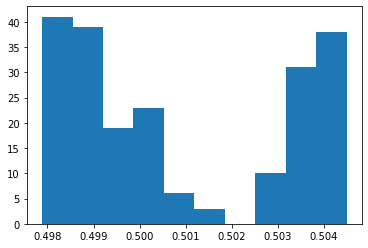

<IPython.core.display.Javascript object>

In [61]:
# Visualize confidence of model.
plt.hist(pred_prob_0)
plt.show()

### Importances

In [62]:
importances = x_pipe_cv.best_estimator_["xgb"].feature_importances_
im_df = pd.DataFrame({"features": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,features,importance
5,home_favorite,0.619530
3,mean_home,0.131736
4,mean_away,0.070191
2,spread_favorite,0.067297
0,team_home,0.059324
1,team_away,0.051923


<IPython.core.display.Javascript object>

### Errors

mean prob of ml win for errors: 0.35714285714285715


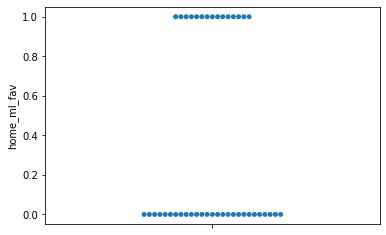

<IPython.core.display.Javascript object>

In [63]:
errors = dfss_copy.copy()
errors = errors.loc[y_test.index]

errors["y_true"] = y_test
errors["y_pred"] = y_predx

errors = errors[errors["y_true"] != errors["y_pred"]]

print(f'mean prob of ml win for errors: {errors["home_ml_fav"].mean()}')


sns.swarmplot(y=errors["home_ml_fav"])
plt.show()

## Try SVM on Money Line outcome for favorited team

In [64]:
pipe = Pipeline([("prep", prep), ("svc", SVC(probability=True))])

grid = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2, 3, 4],
    "svc__C": [0.001, 0.01, 0.1, 1],
}

pipe_cv = GridSearchCV(pipe, grid, cv=2, n_jobs=-1)

<IPython.core.display.Javascript object>

### Fit and Eval

In [65]:
pipe_cv.fit(X_train, y_train)

print("Best params:")
print(pipe_cv.best_params_)

print(f"\ntrain score: {pipe_cv.score(X_train,y_train):.3f}")
print(f"test score: {pipe_cv.score(X_test, y_test):.3f}\n")

y_pred = pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'svc__C': 0.1, 'svc__degree': 2, 'svc__kernel': 'linear'}

train score: 0.798
test score: 0.829

[[91 25]
 [11 83]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       116
           1       0.77      0.88      0.82        94

    accuracy                           0.83       210
   macro avg       0.83      0.83      0.83       210
weighted avg       0.84      0.83      0.83       210



<IPython.core.display.Javascript object>

In [67]:
# Calibration Curve is best to look at probability of 1.
# As it will keep skew from happening.

x_pred_prob_1 = x_pipe_cv.best_estimator_["xgb"].predict_proba(EX_test)[:, 1]

# Run for the SVM model
pred_prob_1 = pipe_cv.best_estimator_["svc"].predict_proba(EX_test)[:, 1]

<IPython.core.display.Javascript object>

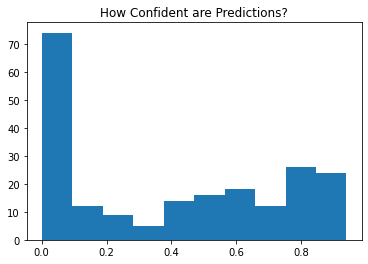

<IPython.core.display.Javascript object>

In [68]:
plt.hist(pred_prob_1)
plt.title("How Confident are Predictions?")
plt.show()

In [69]:
from sklearn.calibration import calibration_curve

# This only cares about positive class (1).
# In a multi class scenario, run multiple times for each class.
prob_true, prob_pred = calibration_curve(y_test, pred_prob_1)
x_prob_true, x_prob_pred = calibration_curve(y_test, x_pred_prob_1)

<IPython.core.display.Javascript object>

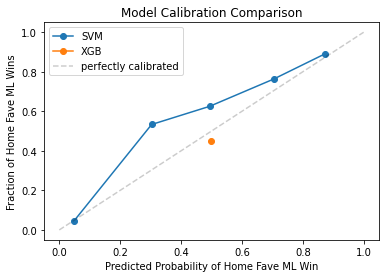

<IPython.core.display.Javascript object>

In [70]:
plt.plot(prob_pred, prob_true, "-o", label="SVM")
plt.plot(x_prob_pred, x_prob_true, "-o", label="XGB")
plt.plot([0, 1], [0, 1], "--", label="perfectly calibrated", c="black", alpha=0.2)
plt.title("Model Calibration Comparison")
plt.xlabel("Predicted Probability of Home Fave ML Win")
plt.ylabel("Fraction of Home Fave ML Wins")
plt.legend()
plt.show()
# below line, means more confident and less accurate.
# XGB model shows a dot. SVM is the better calibrated model.

### Errors

Mean prob of "home team ML win" for errors: 0.5555555555555556


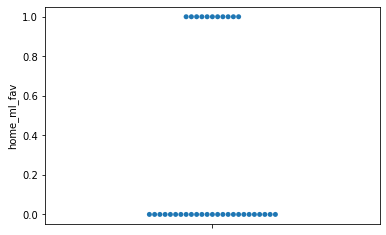

<IPython.core.display.Javascript object>

In [71]:
errors = dfss_copy.copy()
errors = errors.loc[y_test.index]

errors["y_true"] = y_test
errors["y_pred"] = y_pred

errors = errors[errors["y_true"] != errors["y_pred"]]

print(f'Mean prob of "home team ML win" for errors: {errors["is_over"].mean()}')


sns.swarmplot(y=errors["home_ml_fav"])
plt.show()

In [ ]:
# sns.pairplot(X)
# plt.show()

In [74]:
thresh_df = pd.DataFrame({"actual": y_test, "pred_prob": pred_prob_1, "pred": y_pred})
# Set threshholds of trust, and look at how often correct.

bet_w = thresh_df[thresh_df["pred_prob"] > 0.8]
bet_wp = (bet_w["actual"] == bet_w["pred"]).mean()
print(f"Bet on team to win with {bet_wp: .2f}% confidence when model predicts over 80%")


bet_l = thresh_df[thresh_df["pred_prob"] < 0.2]
bet_lp = (bet_l["actual"] == bet_l["pred"]).mean()
print(
    f"Bet on team to lose with {bet_lp:.2f}% confidence when model predicts less than 20%"
)

Bet on team to win with  0.89% confidence when model predicts over 80%
Bet on team to lose with 0.95% confidence when model predicts less than 20%


<IPython.core.display.Javascript object>

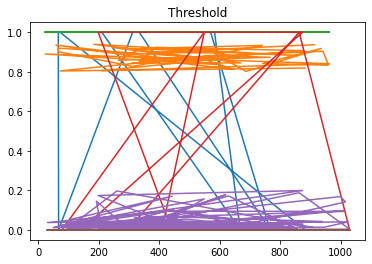

<IPython.core.display.Javascript object>

In [134]:
plt.plot(bet_w)
plt.plot(bet_l)
# plt.plot(thresh_df)
plt.title("Threshold")
plt.show()

## Save model by pickling


In [93]:
# Save to file

best_model = pipe_cv.best_estimator_
with open("saved_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

<IPython.core.display.Javascript object>

In [94]:
X.columns

Index(['team_home', 'team_away', 'spread_favorite', 'mean_home', 'mean_away',
       'home_favorite'],
      dtype='object')

<IPython.core.display.Javascript object>

In [89]:
dfteam

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central
5,Buffalo Bills,Bills,BUF,BUF,AFC,AFC East,AFC,AFC East
6,Carolina Panthers,Panthers,CAR,CAR,NFC,NFC South,NFC,NFC West
7,Chicago Bears,Bears,CHI,CHI,NFC,NFC North,NFC,NFC Central
8,Cincinnati Bengals,Bengals,CIN,CIN,AFC,AFC North,AFC,AFC Central
9,Cleveland Browns,Browns,CLE,CLE,AFC,AFC North,AFC,AFC Central


<IPython.core.display.Javascript object>

In [119]:
display(X[(dfss["team_away"] == "NYJ") & (dfss["schedule_season"] == 2019)].head(1))
X[(dfss["team_home"] == "NE") & (dfss["schedule_season"] == 2019)].head(1)

,team_home,team_away,spread_favorite,mean_home,mean_away,home_favorite
912,JAX,NYJ,-6.5,17.875,15.875,1.0


,team_home,team_away,spread_favorite,mean_home,mean_away,home_favorite
799,NE,NYG,-16.5,23.888889,23.5,1.0


<IPython.core.display.Javascript object>

In [121]:
d = {
    "team_home": ["DET", " NE"],
    "team_away": ["MIN", "NYJ"],
    "spread_favorite": [-3.5, -3],
    "mean_home": [23.5, 23.88],
    "mean_away": [24.8, 15.875],
    "home_favorite": [0, 1],
}
new_data = pd.DataFrame(d)

# Keep the columns in same order
new_data

,team_home,team_away,spread_favorite,mean_home,mean_away,home_favorite
0,DET,MIN,-3.5,23.50,24.800,0
1,NE,NYJ,-3.0,23.88,15.875,1


<IPython.core.display.Javascript object>

In [122]:
# Load from file
with open("saved_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
y_new_pred = loaded_model.predict(new_data)
print(f"predicted: {y_new_pred}")


## TO DO  - find confidence in prediction
# print(f"right answer: {new_data_right_answer.values}")

predicted: [0 1]


<IPython.core.display.Javascript object>

### Compare model to parlay betting strategy

In [77]:
# Model confidence probability for parlays
print(0.89 ** 2, 0.89 ** 3, 0.95 ** 2, 0.95 ** 3, 0.95 ** 4)
0.89 * 0.95 


0.7921 0.7049690000000001 0.9025 0.8573749999999999 0.8145062499999999


0.8454999999999999

<IPython.core.display.Javascript object>

### Parlay typical odds - Real Vs Vegas

- 2 games: 3/1 vs 2.6/1 
- 3 games: 7/1 vs 6/1 
- 4 games: 15/1 vs 10/1

As the amount of games included in a parlay goes up the more Vegas discounts the odds.  For our model we want to cap Parlays at 3 games for maximum effectiveness. 

#### Odds our Model gives when using set confidence thresholds
- Bet Win
    - 2 game: 79%
    - 3 game: 70%

- Bet Lose
    - 2 game: 90%
    - 3 game: 86%
    - 4 game: 81%
- Bet Win / Lose
    - 84.5%
- Bet Win / Lose / Win
    - 75%
- Bet Win / Lose / Lose
    - 80%
    
#### Strategy - run the games for the week and choose games that satisfy the model in 2-3 game parlay combos. 